In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL
from libs.second_appr_simp_t import CorticalColumn, LayerConnection, AbstractRewardSystem, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence

In [2]:
seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

In [3]:
# input_size = 200
# each_session = 40
# session_number = 30

# time = session_number * each_session
# spike_train = torch.zeros(time, input_size)
# timestep_class = torch.zeros(time).bool()

# spike_train = torch.zeros(time, input_size)
# session_class = torch.rand(session_number) < 0.5
# for idx, cls in enumerate(session_class):
#     active_train  = torch.rand(each_session, int(input_size/2)) < 0.3 + (random.random() * 0.15 - 0.075)
#     passive_train = torch.rand(each_session, int(input_size/2)) < 0.1 + (random.random() * 0.15 - 0.075)
    
#     spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] = active_train if cls else passive_train
#     spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] = passive_train if cls else active_train
#     timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [4]:
input_size = 200
each_session = 30
session_number = 300
gap_time = 20

time = session_number * each_session
spike_train = torch.zeros(time, input_size).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2
pattern_size = int(input_size/2)
pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
pattern_1[each_session - gap_time:, :] = 0
pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
pattern_2[each_session - gap_time:, :] = 0

for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] |= pattern_1
    else:
        spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [5]:
spike_train.T[:, 100:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

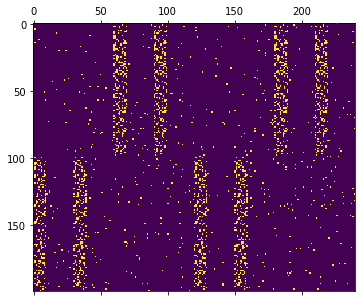

In [6]:
import matplotlib.pyplot as plt

plt.matshow(spike_train.T[:, :8 * each_session])

In [7]:
connection_args_exc = { # Inside Layer
    'wmin': 0.,
    'wmax': 0.2,
    'nu': 0.01,
    'update_rule': PostPre,
}
connection_args_inh = { # Inside Layer
    'wmin': -0.2,
    'wmax': 0,
    'nu': 0.01,
    'update_rule': NoOp,
#     'update_rule': PostPreInh,
}
exc_rec_con_args = { # Exc -> Exc
    'wmin': 0.,
    'wmax': 0.1,
    'nu': 0.01,
    'update_rule': NoOp,
}
connection_args = { # Between Layer
    'wmin': 0.,
    'wmax': 0.4,
    'nu': 0.02,
    'update_rule': MSTDPET_SEASONAL,
}
layer_args_l23 = {
    'exc_size': 200,
    'inh_size': 50,
    'exc_con_args': connection_args_exc,
    'inh_con_args': connection_args_inh,
    'exc_rec_con_args': exc_rec_con_args,
    'exc_args': {
        'traces': True,
#         'refrac': 0
    },
    'inh_args': {
        'thresh': -58.0,
        'traces': True,
#         'refrac': 0
    }
}
layer_args_l4 = {
    'exc_size': 200,
    'inh_size': 50,
    'exc_con_args': connection_args_exc,
    'inh_con_args': connection_args_inh,
    'exc_rec_con_args': exc_rec_con_args,
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 10,
    },
    'inh_args': {
        'thresh': -58.0,
        'tc_trace': 10,
        'traces': True,
#         'refrac': 0
    }
}
connection_type = ConnectionWithConvergence

In [8]:
input_pop_c1 = Input(input_size, traces=True, tc_trace=10)
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, connection_type, name="c1", monitor=LAYER_23|LAYER_4)
input_to_c1_connection = LayerConnection(("input_c1", input_pop_c1), c1, connection_type, {
    'wmin': 0.,
    'wmax': 0.5,
    'nu': 0.01,
#     'update_rule': MSTDPET_SEASONAL,
    'update_rule': PostPre,
})

In [9]:
# class C1Reward(AbstractRewardSystem):
#     def __init__(self):
#         super().__init__()
#         self.set_cortical_column_and_classes(c1, timestep_class)

In [10]:
network = Network(dt=1.0) #, reward_update=True, reward_fn=C1Reward)
network.add_layer(input_pop_c1, "input_c1")
inp_monitor = Monitor(obj=input_pop_c1, state_vars=['s'])

inp_2_c1_monitor_1 = Monitor(obj=input_to_c1_connection.connections[0][2], state_vars=['converge'])
inp_2_c1_monitor_2 = Monitor(obj=input_to_c1_connection.connections[1][2], state_vars=['converge'])

network.add_monitor(monitor=inp_monitor, name="input_c1")
network.add_monitor(monitor=inp_2_c1_monitor_1, name="inp_2_c1_monitor_1")
network.add_monitor(monitor=inp_2_c1_monitor_2, name="inp_2_c1_monitor_2")
c1.add_to_network(network)
input_to_c1_connection.add_to_network(network)

In [11]:
# from tqdm import trange

# rewards = []
# changes = []
# # inputs = {'input_c1' : spike_train}
# for part in trange(session_number, unit="parts"):
# # for part in trange(1, unit="parts"):
    
#     inp = {'input_c1': spike_train[part*each_session:part*each_session+each_session, :]}
#     network.run(inputs=inp, time=each_session)
    
    
#     exc1_act = c1.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()
#     exc2_act = c1.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()
# #     print(exc1_act, exc2_act)
#     pattern = session_class[part]
#     gap_check = abs(exc2_act - exc1_act) > 10
    
#     exc1_wins = exc1_act > exc2_act
#     reward = 1 if (exc1_wins == pattern) and gap_check else -1
#     rewards.append(reward * 3)
    
#     #TODO Get trigger of connection
#     for conn in c1.l4_l23.connections:
# #     for conn in c1.l4_l23.connections + input_to_c1_connection.connections:
#         change = conn[2].update_rule.trigger(reward)
#         changes.append(change)
        
# #     c1.pops_reset_state_variables()

In [12]:
from tqdm import trange

rewards = []
changes = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):
    
    inp = {'input_c1': spike_train[part*each_session:part*each_session+each_session, :]}
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c1.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c1.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c1.l23.monitors[0][1].get('s')[-each_session:,0,:].sum() - exc1_avg
    exc2_act = c1.l23.monitors[1][1].get('s')[-each_session:,0,:].sum() - exc2_avg
    
#     print(exc1_act, exc2_act)
    pattern = session_class[part]
    gap_check = abs(exc2_act - exc1_act) > 10
    
    exc1_wins = exc1_act > exc2_act
    reward = 1 if (exc1_wins == pattern) and gap_check else -0.2
    rewards.append(reward)
    
    #TODO Get trigger of connection
    for conn in c1.l4_l23.connections:
#     for conn in c1.l4_l23.connections + input_to_c1_connection.connections:
        change = conn[2].update_rule.trigger(reward)
        changes.append(change)
        
#     c1.pops_reset_state_variables()

100%|█████████████| 300/300 [00:38<00:00,  7.74parts/s]


In [13]:
rewards

[-0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 1,
 -0.2,
 -0.2,
 1,
 1,
 -0.2,
 1,
 1,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 1,
 -0.2,
 -0.2,
 1,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 1,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 1,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 1,
 -0.2,
 -0.2,
 -0.2,
 1,
 -0.2,
 -0.2,
 1,
 1,
 1,
 1,
 -0.2,
 1,
 1,
 -0.2,
 1,
 -0.2,
 1,
 1,
 1,
 -0.2,
 1,
 1,
 1,
 -0.2,
 1,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.2,
 -0.

In [14]:
# for i in range(100):
#     x = torch.linspace(-0.05, 0.05, steps=40)
#     plt.bar(x, torch.histc(changes[i], bins=40, min=-0.05, max=0.05), align='center', width=0.002)
#     plt.figure()

## Convergence

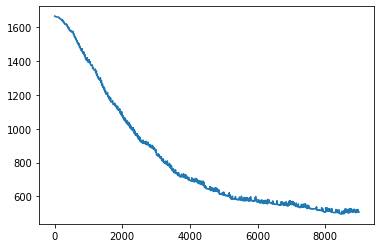

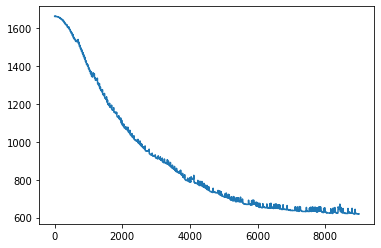

In [15]:
plt.plot(inp_2_c1_monitor_1.get('converge'))
plt.figure()
plt.plot(inp_2_c1_monitor_2.get('converge'))

In [20]:
time_show = 12000

In [21]:
spikes = {
    "L4 | 1": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c1.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
#     "L4 | I": c1.l4.monitors[2][1].get('s')[-time_show:,0,:].T, 
#     "L23 | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
#     "L23 | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
#     "L23 | I": c1.l23.monitors[2][1].get('s')[-time_show:,0,:].T, 
}

## Confusion

In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / session_class[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    19.755556106567383
L4 -- Excitatory 1 -- Pattern 2     :    244.44444274902344
L4 -- Excitatory 2 -- Pattern 1     :    196.91111755371094
L4 -- Excitatory 2 -- Pattern 2     :    13.066666603088379


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / session_class.sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    80.19117736816406
L4 -- Excitatory 1 -- Pattern 2     :    226.6764678955078
L4 -- Excitatory 2 -- Pattern 1     :    189.3455810546875
L4 -- Excitatory 2 -- Pattern 2     :    65.64705657958984


## Pattern Separation

In [24]:
for source, target, connection in input_to_c1_connection.connections:
    print(f"{source} (0:99)    --->   {target}   :   {connection.w[:100, :].sum()}")
    print(f"{source} (100:199) --->   {target}   :   {connection.w[100:, :].sum()}")

input_c1 (0:99)    --->   c1_l4__exc1   :   2347.714111328125
input_c1 (100:199) --->   c1_l4__exc1   :   2669.509765625
input_c1 (0:99)    --->   c1_l4__exc2   :   2572.735107421875
input_c1 (100:199) --->   c1_l4__exc2   :   2433.7099609375


## Activities

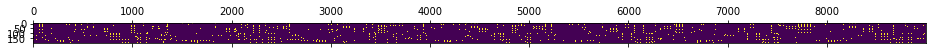

In [25]:
plt.matshow(spike_train.T[:, -time_show:])

In [26]:
c1.l4.monitors[0][1].get('s').shape

torch.Size([9000, 1, 200])

In [27]:
spikes["L4 | 1"].shape

torch.Size([200, 9000])

In [28]:
spikes["L4 | 1"].sum(0).shape[0]

9000

In [29]:
ver_num = 2
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(200, 200), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')